In [67]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
# https://github.com/pytorch/examples/blob/master/vae/main.py
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from torchvision.transforms import ToPILImage
from IPython.display import Image
class Args:
    def __init__(self, batch_size, epochs, no_cuda, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.no_cuda = False
        self.seed = 1
        self.log_interval = log_interval
    
args = Args(batch_size=128, epochs=10, no_cuda=False, seed=1, log_interval=100)
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)



class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

                #to_img = ToPILImage(comparison)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        sample.view(64, 1, 28, 28)
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 164.4719
====> Test set loss: 127.0146
====> Epoch: 2 Average loss: 121.7924
====> Test set loss: 116.3492
====> Epoch: 3 Average loss: 114.8201
====> Test set loss: 112.1995
====> Epoch: 4 Average loss: 111.6513
====> Test set loss: 109.8997
====> Epoch: 5 Average loss: 109.9630
====> Test set loss: 108.5224


Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter-0; Loss: 760.1
Iter-1000; Loss: 144.3
Iter-2000; Loss: 134.6
Iter-3000; Loss: 126.3
Iter-4000; Loss: 116.8
Iter-5000; Loss: 119.5
Iter-6000; Loss: 112.7
Iter-7000; Loss: 113.5
Iter-8000; Loss: 114.0
Iter-9000; Loss: 106.6


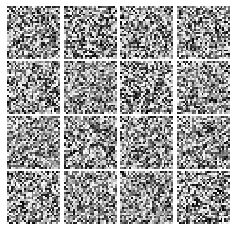

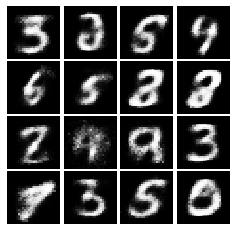

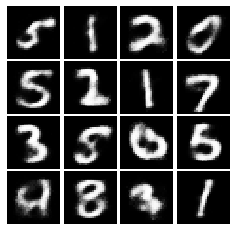

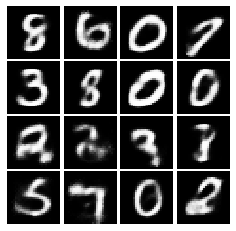

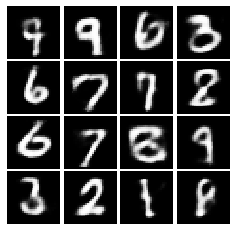

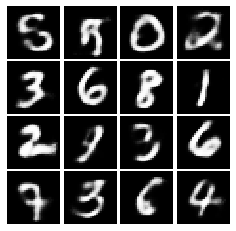

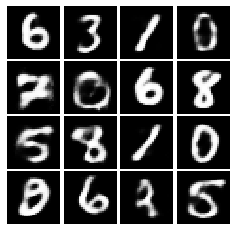

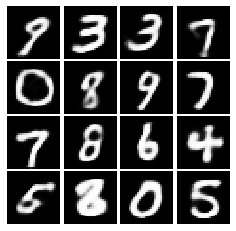

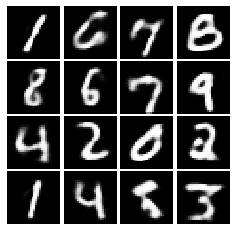

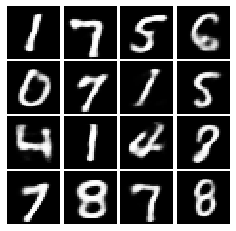

In [11]:
#source: https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/

import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


# =============================== Q(z|X) ======================================

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


# =============================== TRAINING ====================================

params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

for it in range(10000):
    X, _ = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))

    # Forward
    z_mu, z_var = Q(X)
    z = sample_z(z_mu, z_var)
    X_sample = P(z)

    # Loss
    recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    # Backward
    loss.backward()

    # Update
    solver.step()

    # Housekeeping
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.data.item()))

        samples = P(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        #plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        #plt.close(fig)
plt.show()

In [24]:
show_image(comparison)

NameError: name 'show_image' is not defined

NameError: name 'comparison' is not defined